**Проект телекоммуникации**

## Описание проекта: телекоммуникации

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг:

Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
Также доступны такие услуги:

 - Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
 - Выделенная линия технической поддержки (TechSupport);
 - Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
 - Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

 - contract.csv — информация о договоре;
 - personal.csv — персональные данные клиента;
 - internet.csv — информация об интернет-услугах;
 - phone.csv — информация об услугах телефонии.

### Описание полей данных

 - BeginDate – дата начала пользования услугами.
 - EndDate – дата окончания пользования услугами.
 - Type – тип оплаты: ежемесячный, годовой и тд.
 - PaperlessBilling – безналичный расчет.
 - PaymentMethod – способ оплаты.
 - MonthlyCharges – ежемесячные траты на услуги.
 - TotalCharges – всего потрачено денег на услуги.
 - Dependents – наличие иждивенцев.
 - Senior Citizen – наличие пенсионного статуса по возрасту.
 - Partner – наличие супруга(и).
 - MultipleLines – наличие возможности ведения параллельных линий во время звонка.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## План работы

1. Загрузить данные, сделать их предварительный анализ: рассмотреть и проанализировать каждый набор данных, посмотреть взаимосвязи.

2. Провести предобработку данных, объединить данные, подготовить признаки и, при необходимости, добавить новые признаки. Выделить/создать целевой признак. Сделать исследовательский анализ данных (EDA) и выводы по результатам EDA.

3. Разделить итоговый датасет на тренировочную и тестовую выборки. В случае необходимости, провести кодирование и масштабирование.

4. Определить модели, подходящие для исследования (предварительно предполагается использовать Классификаторы LogisticRegression, CatBoost, LightGBM и одну из ассемблинговых моделей), провести подбор гиперпараметров, выделить важные фичи.

5. Сравнить модели по результатам кросс-валидации и оценить эффективность лучшей модели на тестовой выборке.

6. Провести анализ влияния различных факторов лучшей модели.

7. Общий вывод по результатам исследования.

PS: В процессе проведения исследования, план работ может быть скорректирован исходя из полученных результатов, а также в случае появления других дополнительных предпосылок.

In [ ]:
!pip install -U catboost

In [ ]:
!pip install -U seaborn

In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip install phik

In [ ]:
! pip install shap

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import phik
import shap

from time import time
# import tqdm
from tqdm.notebook import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv
from lightgbm import LGBMClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    cross_val_score
)

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, make_scorer, roc_curve

RST = 30723

In [ ]:
contract = pd.read_csv('/datasets/contract_new.csv', index_col=['customerID'],
                          parse_dates=['BeginDate', 'EndDate'])
personal = pd.read_csv('/datasets/personal_new.csv', index_col='customerID')
internet = pd.read_csv('/datasets/internet_new.csv', index_col='customerID')
phone = pd.read_csv('/datasets/phone_new.csv', index_col='customerID')

## Предварительный анализ данных

### Проанализируем таблицу **сontract**

In [ ]:
contract.head()

In [ ]:
contract.info()

In [ ]:
#Проверим на пропуски
contract.isna().sum()

In [ ]:
# Проверим задвоенные значения
contract.index.duplicated().sum()
#contract.duplicated()

In [ ]:
contract['EndDate'].value_counts()

In [ ]:
contract['BeginDate'].value_counts().sort_values(ascending = True)

In [ ]:
contract['BeginDate'].hist(figsize=(12,6))

In [ ]:
contract['Type'].hist(figsize=(12,6))

In [ ]:
contract['PaperlessBilling'].hist(figsize=(12,6))

In [ ]:
contract['PaymentMethod'].hist(figsize=(12,6))

In [ ]:
contract.groupby('Type')['MonthlyCharges'].count()

In [ ]:
# Построим распределение признака `MonthlyCharges`
contract['MonthlyCharges'].hist(bins=100, figsize=(12,6))

Вывод по таблице **contract**

- данные готовы для анализа, пропусков и дублирующих значений нет.
- необходимо изменить тип данных для признаков BeginDate, EndDate, MonthlyCharges, TotalCharges
- большенство клиентов выбирают платить каждый месяц. При этом, количество клиентов, которые оплачивают сразу на 2 года, больше, чем те, кто  оплачивают год.
- Чаще клиенты выбирают электронную оплату. 
- еобходимо подробнее изучить ежемесячную оплату, изучить выброс в ней и распредение.


### Проанализируем таблицу **personal**

In [ ]:
personal.head()

In [ ]:
personal.info()

In [ ]:
# Проверим наличие пропусков
personal.isna().sum()

In [ ]:
# Проверим задвоенные значения
personal.index.duplicated().sum()

In [ ]:
# Распределение 
personal['gender'].hist(figsize=(5,4))
plt.title('Пол клиента');

In [ ]:
personal['SeniorCitizen'].value_counts(normalize = True)

In [ ]:
personal['Partner'].value_counts(normalize = True)

In [ ]:
personal['Dependents'].value_counts(normalize = True)

Вывод по таблице **personal**
 - данные готовы для анализа, пропусков и дублирующих значений нет.
 - Клиенты распределены почти поровну по половому признаку.
 - Доля стариков значительно меньше, около 16%.
 - Доля женатых клиентов и неженатых клиентов - практически одинакова.
 - Отмечается перевес клиентов,  у которых нет иждивенцев. 

### Проанализируем таблицу **internet**

In [ ]:
internet.head()

In [ ]:
internet.info()

In [ ]:
#Проверим на пропуски
internet.isna().sum()

In [ ]:
# Проверим задвоенные значения
internet.index.duplicated().sum()

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=[20,15])
plot_number=1
for i in internet.columns:
    ax=plt.subplot(3,3,plot_number)
    sns.histplot(internet[i])
    plot_number+=1

plt.tight_layout()
plt.show()

In [ ]:
print('Тип интернет подключения:')
internet['InternetService'].value_counts(normalize = True)

In [ ]:
print('OnlineSecurity:')
internet['OnlineSecurity'].value_counts(normalize = True)

In [ ]:
print('OnlineBackup:')
internet['OnlineBackup'].value_counts(normalize = True)

In [ ]:
print('TechSupport:' )
internet['TechSupport'].value_counts(normalize = True)

In [ ]:
print('DeviceProtection:') 
internet['DeviceProtection'].value_counts(normalize = True)

In [ ]:
print('Стриминговое телевидение')
internet['StreamingTV'].value_counts(normalize = True)

In [ ]:
print('Каталог фильмов')
internet['StreamingMovies'].value_counts(normalize = True)

Вывод по таблице **internet**
 - данные готовы для анализа, пропусков и дублирующих значений нет.
 - количество записей меньше, чем в предыдущих таблицах.В этом наборе данных присутсвуют уже не все пользователи, так не все клиенты компнии пользуются доступом в Интернет через этого провайдера.
 - пользователи чаще выбирают оптоволокно
 - услугами безопасности и техподдержкой пользуется меньшая половина позователнй 
 - в стриминговых услугах почти равное распределение пользователей.

### Проанализируем таблицу **phone**

In [ ]:
phone.head()

In [ ]:
phone.info()

In [ ]:
#Проверим на пропуски
phone.isna().sum()

In [ ]:
# Проверим задвоенные значения
phone.index.duplicated().sum()

In [ ]:
phone['MultipleLines'].hist()
plt.title('Возможность ведения параллельных линий');

Вывод по таблице **phone**

 - данные готовы для анализа, пропусков и дублирующих значений нет.
 - только часть клиентов использует услугу телефонии.
 - у большинства пользователй отсутствует функция ведения параллельных линий

## Предобработка и исследовательский анализ данных (EDA)

### Предобработка данных

Добавим категориальный признак

In [ ]:
contract['target'] = (contract['EndDate'] != 'No').astype(int)

Перобразуем тип данных у признаков BeginDate, EndDate, MonthlyCharges, TotalCharges и заменим пропущенные значения

In [ ]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

In [ ]:
contract['MonthlyCharges'] = contract['MonthlyCharges'].astype(float)

In [ ]:
contract['EndDate'] = contract['EndDate'].replace('No', '2020-02-01')
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

In [ ]:
contract.query('TotalCharges ==  " "')

Все пропуски обьясняются банальным отсутствием комисии, т.к. клиенты не пользовались услугами компании 

In [ ]:
contract['TotalCharges'] = contract['TotalCharges'].replace(' ', '0')
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

In [ ]:
# проверка contract['TotalCharges'].value_counts()

In [ ]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype(str) # добавил для OHE

Добавление дополнительных признаков

In [ ]:
# Количество дней в течение которых клиент  пользовался услугами
contract['period'] = (contract['EndDate'] - contract['BeginDate']).dt.days

In [ ]:
#В таблицы internet и phone добавим признаки для информативности при объединении
internet['Internet'] = '1'
phone['Phone'] = '1'

Объединение признаков

In [ ]:
# contract = contract.join(personal)
# contract = contract.join(internet)
# contract = contract.join(phone)

contract = pd.merge(contract, personal, left_index=True, right_index=True, how='left' )
contract = pd.merge(contract, internet, left_index=True, right_index=True, how='left' )
contract = pd.merge(contract, phone, left_index=True, right_index=True, how='left' )

In [ ]:
df=contract.copy()

In [ ]:
df.info()

In [ ]:
df = df.fillna('No')

In [ ]:
# Категориальная переменная на основании вышеуказанной
# contract['q_period'] = pd.qcut(contract['period'], 3)
# contract['q_period']
df['cl_cat'] = pd.qcut(df['period'], 3, labels=['1','2','3'])
df['cl_cat']

In [ ]:
df.info()

In [ ]:
df.head(20)

### Исследовательский анализ данных (EDA). 

In [ ]:
df.phik_matrix()

Наблюдается мультиколлениарность между рядом признаков: target, EndDate,  period  и BeginDate. Это весьма логично, т.к. признаки  target и period  строились на основании BeginDate и EndDate. Чтобы избежать проблемы переобучения, при подготовке датасета для машинного обучения, BeginDate и EndDate необходимо будет удалить.

In [ ]:
ph_t = df.phik_matrix()
ph_t.iloc[:, 7].sort_values(ascending=True).plot.barh(figsize = (14,10), label='probability', color='b', legend=True)
plt.title('Влияние параметров на результирующий признак', fontsize=32)
plt.show()

In [ ]:
phik_overview = df.phik_matrix()
phik_overview['target'].sort_values(ascending=False)

Вышеукзанный график показывает "вклад" каждого признака в общий результат. 

Распределение целевого признака

In [ ]:
df['target'].hist(figsize=(12,6))
plt.title('Баланс классов');

In [ ]:
df['target'].value_counts()

In [ ]:
df['target'].value_counts(normalize = True)

Наблюдается существенный дисбаланс целевого признака. Только 15,6 % клиентов отвергли сервис заказчика.

In [ ]:
sns.pairplot(df, hue = 'target')

На графике видно что плоность ушедших клиентов больше у дорогих клиентов, у которых ежемесечный платеж выше. Необходимо разобрать отдельно. С точки зрения общих платежей, очень ушедших клиентов, кто обеспечил существенную выручку компании. 

In [ ]:
f, axes = plt.subplots(1, 1, figsize=(18, 9))
axes.set_title('Распределения доли ежемесячных платежей клиентов', fontsize=22)
axes.set_ylabel('Количество значений', fontsize=15)
sns.histplot(df[df['target'] == 0]['MonthlyCharges'], bins=30, color = 'b')
sns.histplot(df[df['target'] == 1]['MonthlyCharges'], bins = 30, color = 'r')
axes.set_xlabel('Размер выручки', fontsize=15)
plt.axvline(df[df['target']  == 0]['MonthlyCharges'].mean(), 0, color = 'b', linestyle='--', linewidth = 4)
plt.axvline(df[df['target']  == 1]['MonthlyCharges'].mean(), 0, color = 'r', linestyle='--', linewidth = 4)
axes.legend(labels=["Среднее значение для действующих клиентов","Среднее значение для ушедших клиентов", 
                    "Оставшиеся клиенты","Ушедшие клиенты"], fontsize=12);

Из графика видно, что уходят клиенты с большим среднемесячным платежом

**Вывод по результатам EDA.**

 - Был проведен исследовательский анализ данных.
 - Выявлен дизбаланс классов результирующего признака.
 - Показано,  что в основном ушедшие клиенты были те, у которых ежемесечный платеж был от 70 до 110.
 - Также наблюдается нулевая корреляция между результирующим признаком и использованием услуг телефони, т.е. аказчик в первую очередь выступает, телефонным оператором, а уже потом как интернет провайдер.
 - Используя пакет Phik, рассмотрели какие параметры оказывают наибольшее влияние на конечный резульат.
 -  Была выявлена мультиколлениарность между рядом признаков: target, EndDate, period и BeginDate. Это весьма логично, т.к. мы построили признаки target и period на основании BeginDate и EndDate. Чтобы избежать проблемы переобучения, при подготовке датасета для машинного обучения, BeginDate и EndDate необходимо будет удалить.
 


##  Разделение датасета на тренировочную и тестовую выборки. Кодирование и масштабирование

In [ ]:
df.columns#.to_list()
df.dtypes

In [ ]:
#Удаляем лишние ячейки
data = df.drop(['EndDate', 'BeginDate'], axis=1,  errors='ignore') #inplace= True,
data.columns

In [ ]:
# features = df.drop('target', axis=1)
# target = df['target']
X=[col for col in data.columns if col != 'target']
y=['target']
X

In [ ]:
numeric_features = ['MonthlyCharges', 'TotalCharges', 'period']

In [ ]:
cat_features = [col for col in data.columns if (col not in numeric_features) and  (col != 'target')]
cat_features

In [ ]:
X_train, X_test, y_train, y_test, = train_test_split(data[X], data[y], test_size=0.25, stratify=data[y], random_state=RST)        

In [ ]:
print(f"Количество строк в X_train по классам: {X_train.shape[0]}")
print(f"Количество строк в X_test по классам: {X_test.shape[0]}")

print(f"Количество строк в y_train по классам: {y_train.shape[0]}")
print(f"Количество строк в y_test по классам: {y_test.shape[0]}")


print(f"Пропорция по X: {X_test.shape[0]/X_train.shape[0]}")
print(f"Пропорция по y: {y_test.shape[0]/y_train.shape[0]}")

In [ ]:
train = pd.merge(X_train, y_train, left_index=True, right_index=True, how='left' )
test = pd.merge(X_test, y_test, left_index=True, right_index=True, how='left' )

In [ ]:
print(f"Количество строк в train по классам: {train.shape}")
print(f"Количество строк в test по классам: {test.shape}")

Создадим два набора данных. Один оставим без преобразования (для использования в PipeLine и для бустинговых моделей), а второй стандартизируеи и закодируем.

In [ ]:
X_train_st = X_train.copy()
X_test_st = X_test.copy()
y_train_st = y_train.copy()
y_test_st = y_test.copy()

Кодируем признаки методом OHE

In [ ]:
X_train_st[cat_features].dtypes

In [ ]:
X_train_st['MultipleLines'].value_counts()

In [ ]:
ohe_features = cat_features #['MonthlyCharges', 'TotalCharges', 'period']

In [ ]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)

In [ ]:
encoder_ohe.fit(X_train_st[ohe_features])

In [ ]:
X_train_st[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_train_st[ohe_features])

In [ ]:
X_train_st = X_train_st.drop(ohe_features, axis=1)

In [ ]:
X_test_st[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_test_st[ohe_features])

In [ ]:
X_test_st = X_test_st.drop(ohe_features, axis=1)

In [ ]:
X_train_st.head()

Cтандартизируем признаки 

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_st[numeric_features])
X_train_st[numeric_features] = scaler.transform(X_train_st[numeric_features])
X_test_st[numeric_features]  = scaler.transform(X_test_st[numeric_features])

## Моделирование

In [ ]:
%%time
# Логистическая регрессия
#  https://stackoverflow.com/questions/39163354/evaluating-logistic-regression-with-cross-validation
model_log = LogisticRegression(solver = 'liblinear', random_state=RST, class_weight='balanced')
roc_auc_log = cross_val_score(model_log, X_train_st, y_train_st, cv=4,scoring='roc_auc').mean()
print (roc_auc_log)

In [ ]:
%%time
# Случайный лес

model_rf = RandomForestClassifier(random_state=RST)

param_grid_rf = {
    'n_estimators': range(50, 251, 50),
    'max_depth': range(2, 15),
    'min_samples_split': (2, 3, 4),
    'min_samples_leaf': (1, 2, 3, 4)
}
model_rf.fit(X_train_st, y_train_st) 

In [ ]:
%%time
rf_grid = RandomizedSearchCV(model_rf,  param_grid_rf, scoring='roc_auc', cv=4)
rf_grid.fit(X_train_st, y_train_st)

In [ ]:
rf_grid.best_params_

In [ ]:
roc_auc_rf = rf_grid.best_score_
roc_auc_rf

In [ ]:
grid = {'learning_rate': [0.01, 0.05, 0,1],
        'depth': [4, 6],
        'l2_leaf_reg': [1, 3, 5]}

#grid = {'learning_rate': [0.03, 0.1]}

params = {'cat_features': cat_features,
              'eval_metric': 'AUC',
               'eval_metric': 'AUC',
              'random_seed': RST,
              'iterations' :1000, 
              'early_stopping_rounds': 200,
              'verbose':200}

cat_model = CatBoostClassifier(**params)

cv_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features, has_header=True)    
grid_search_result = cat_model.grid_search(grid, cv_dataset, cv=2 )


In [ ]:
# cat_search = GridSearchCV(cat_model, grid, cv=5, scoring='roc_auc')
cat_search = cv(cat_model, grid, cv=5, scoring='roc_auc')
cat_search.fit(X_train, y_train)

In [ ]:
cat_model.best_score_

In [ ]:
cat_model.get_params()

In [ ]:
for key,value in cat_model.get_all_params().items():
    print('{}, {}'.format(key,value))

In [ ]:
cv_roc_cat= cross_val_score(cat_search, X_train, y_train, cv=2,  verbose=20)

In [ ]:
roc_auc_cat= cv_roc_cat.mean()
print('ROC_AUC Catboost:', roc_auc_cat)


LightGBM

In [ ]:
%%time
#LightGBM
import lightgbm
lgbm_train_data = lightgbm.Dataset(X_train, label=y_train, )

X_train[cat_features].astype('category')

LightGBM_model = LGBMClassifier()
hyperparams = [{'max_depth' : [1], # -1, 1
                'learning_rate':[0.3], 
                'n_estimators' : [100],  # 200
                'random_state':RST}]


lgcv = GridSearchCV(LightGBM_model, hyperparams, scoring='roc_auc',cv=3)
LightGBM_model.fit(X_train_st, y_train_st)

In [ ]:
cv_roc_lgbm = cross_val_score(LightGBM_model, X_train_st, y_train_st, cv=4, verbose=20)

In [ ]:
roc_auc_lg= cv_roc_lgbm.mean()
print('ROC_AUC LGBM:', roc_auc_lg)

## Сравнить модели и оценить их эффективность на тестовой выборке

In [ ]:
result = pd.DataFrame(
    [roc_auc_log, roc_auc_rf, roc_auc_cat, roc_auc_lg], 
    index=['LogisticRegression', 'RandomForest', 'CatBoostClassifier', 'LGBM'], 
    columns=['ROC-AUC']
)
result

Лучший результат на трейнинговой выборке показал CatBoost

In [ ]:
# predicted_probalities = cat_search.best_estimator_.predict_proba(X_test)[:, 1]
probabilities_valid = cat_search.best_estimator_.predict_proba(X_test)
probabilities_one_test = probabilities_valid[:, 1]

roc_auc = roc_auc_score(y_test, probabilities_one_test)
roc_auc

In [ ]:
predict_test = cat_search.best_estimator_.predict(X_test)

print('Метрики CatBoost')
print('ROC AUC:', roc_auc_score(y_test, probabilities_one_test))
print('F1:', f1_score(y_test, predict_test))
print()


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


plt.xlim([-0.02,1])
plt.ylim([-0.02,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr, tpr, label='CatBoost')
plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

In [ ]:
# model.get_feature_importance(prettified=True)
# phik_overview['Exited'].sort_values(ascending=False)

In [ ]:
importances_df = pd.DataFrame(cat_search.best_estimator_.feature_importances_, index = X_test.columns, columns=['importances'])
importances_df = importances_df.sort_values(by='importances', ascending=False)
importances_df

In [ ]:
importances_df.plot(kind='barh', figsize=(10, 8), title='Важность факторов')
plt.show()

**Shap**

In [ ]:
! pip install shap

In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[X])

In [ ]:
shap.summary_plot(shap_values, test[X])

In [ ]:
shap.dependence_plot("NumOfProducts", shap_values, test[X])

**Дополнительное задание**

In [ ]:
# test['y_score_no_cross_val'] = model.predict_proba(test_data)[:,1]

In [ ]:
# probabilities_valid = cat_search.best_estimator_.predict_proba(X_test)
# probabilities_one_test = probabilities_valid[:, 1]

# roc_auc = roc_auc_score(y_test, probabilities_one_test)
# roc_auc

# cat_search.best_estimator_.predict_proba(X_test)

In [ ]:
test['score_catboost'] = cat_search.best_estimator_.predict_proba(X_test)[:,1]

In [ ]:
test

In [ ]:
plt.style.use('dark_background')
test['score_catboost'].hist()

In [ ]:
test['y_pred'] = (test['score_catboost'] > 0.5) * 1

In [ ]:
test['y_pred'].mean()

In [ ]:
confusion_matrix(test[y],test['y_pred'])

In [ ]:
tn, fp, fn, tp = confusion_matrix(test[y],test['y_pred']).ravel()

In [ ]:
tn, fp, fn, tp

In [ ]:
test['y_pred_new'] = (test['score_catboost'] > 0.4) * 1

In [ ]:
f1_score(test[y],test['y_pred'])

In [ ]:
f1_score(test[y],test['y_pred_new'])

In [ ]:
len(test['score_catboost'])

In [ ]:
test['score_catboost'].nunique()

In [ ]:
thrs = [0] + list(test['score_catboost'].unique())

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
result = []
for thr in tqdm(thrs):
    test['y_pred_new'] = (test['score_catboost'] > thr) * 1
    result.append((thr, f1_score(test[y],test['y_pred_new'])))

In [ ]:
t = pd.DataFrame(result,columns=['thr','f1'])

In [ ]:

t.sort_values('f1',ascending=False)


In [ ]:
t[t['f1'] == t['f1'].max()]

In [ ]:
test['y_pred_new'] = (test['score_catboost'] > 0.49978) * 1

In [ ]:
confusion_matrix(test[y],test['y_pred_new'])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test[y],test['y_pred'])

In [ ]:
accuracy_score(test[y],test['y_pred_new'])

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(test[y],test['y_pred']))

In [ ]:
print(classification_report(test[y],test['y_pred_new']))

In [ ]:
result1 = []
for thr in tqdm(thrs):
    test['y_pred_new'] = (test['score_catboost'] > thr) * 1
    result.append((thr, accuracy_score(test[y],test['y_pred_new'])))

In [ ]:
t1 = pd.DataFrame(result1,columns=['thr','accur'])
t1

In [ ]:
t1.sort_values('accur',ascending=False)

In [ ]:
t1[t1['accur'] == t1['accur'].max()]

## Общий вывод по результатам исследования

В рамках проекта было проведено исследование поведения клиентов оператора связи «Ниединогоразрыва.ком». 


На первом этапе были загружены данные, сделан их предварительный анализ.
Сделан исследовательский анализ данных (EDA).  Сделана визуализация влияния признаков с использованием пакета phik.

Были построены модели машинного обучения и подобранны гиперпараметры.
Были обучены 4 модели:

 - LogisticRegression,
 - RandomForestClassifier
 - CatBoostClassifier
 - LGBM

 - Лучший результат показала модель CatBoostClassifier со значением ROC-AUC на тестовой выборке 0.91, что выше, чем требуемое значение.

 - Самые важные факторы - сколько клиент пользуется услугами и сколько он платит в месяц

# Отчет по итогам проекта

Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
Исследование в рамках проекта было проведено в соответствии с первоначально составленным планом, в котором были предусмотрены все необходимые шаги, чтобы добиться основной цели проекта.

Первоначальный план проекта:

1. Загрузить данные, сделать их предварительный анализ: рассмотреть и проанализировать каждый набор данных, посмотреть взаимосвязи.
2. Провести предобработку данных, объединить данные, подготовить признаки и, при необходимости, добавить новые признаки. Выделить/создать целевой признак. Сделать исследовательский анализ данных (EDA) и выводы по результатам EDA.
3. Разделить итоговый датасет на тренировочную и тестовую выборки. В случае необходимости, провести кодирование и масштабирование.
4. Определить модели, подходящие для исследования (предварительно предполагается использовать Классификаторы LogisticRegression, CatBoost, LightGBM и одну из ассемблинговых моделей - RandomForest), провести подбор гиперпараметров, выделить важные фичи.
5. Сравнить модели по результатам кросс-валидации и оценить эффективность лучшей модели на тестовой выборке.
6. Провести анализ влияния различных факторов лучшей модели.
7. Общий вывод по результатам исследования.

Все пункты первоначального плана проекта были выполнены, новых глобальных задач не появилось.

В ходе роботы над проектом был сделано:
 - Установлены или обновлены необходимые пакеты Jupyter, которые отсутствовали в тренажере.
 -  Импортированы библиотеки, которые использовались для анализа.
 - Загружены первоначальные данные.
 - Произведен предварительный анализ данных, что дало понимание, каким образом их необходимо подготовить для машинного обучения. В рамках анализа, дынные были проверены на отсутствие пропусков, дубликаты, а также проанализированы их типы.

- В рамках предобработки данных были добавлены дополнительные признаки, а также изменили типы данных у уже имеющихся. Осуществлена сборка всех датасетов в один большой, заполнены образовавшиеся пропуски.

    •	Добавили категориальный признак «target», показывающий уход клиента от компании.

    •	Преобразовали типы данных у признаков BeginDate и EndDate (на datetime), MonthlyCharges, TotalCharges (на float), а также заменены пропущенные значения.

    •	Предварительно в столбце 'EndDate' значения 'No' были заменены на текущую дату - '2020-02-01', а пропуски в столбце 'TotalCharges' - на '0'.

    •	Добавлен признак 'period' - количество дней, в течение которых клиент пользовался услугами компании

    •	На основании вышеуказанного признака, создали также категорийный признак 'cl_cat', состоящий из 3 категорий.

    •	В датасеты Internet и Phone были добавим признаки, показывающие пользуются ли клиенты этими услугами. Это сделано для объединения в один датасет, чтобы не потерять информативность при объединении

    •	объединения таблиц в один большой датасет было сделано с помощью функции «merge» по Индексам, т.к. поле id клиента было занесено как Индекс в каждом датасете при импортировании данных

    •	При создании одного большего датасета, образовались пропуски так как в 2х датасетах отсутствуют некоторое количество клиентов. Пропуски были заменены на «No».

В дальнейшем, также пришлось поменять тип параметра «SeniorCitizen» с Int на String. Это было сделано, т.к. этот параметр был отнесен в разряд категориальных переменных, а CatBoost принимает в качестве таких переменных только данные , которые не имеют формат Integer.

Исследовательских анализ данных, в котором были детально рассмотрены особенности полученного дата сета, показал:
 -	Выявлен дисбаланс классов результирующего признака.
 -	Показано, что в основном ушедшие клиенты были те, у которых ежемесячный платеж был от 70 до 110.
 -	Также наблюдается нулевая корреляция между результирующим признаком и использованием услуг телефони, т.е. аказчик в первую очередь выступает, телефонным оператором, а уже потом как интернет провайдер.
 - Используя пакет Phik, рассмотрели какие параметры оказывают наибольшее влияние на конечный результат. Сделана визуализация влияния признаков.
 - Была выявлена мультиколлениарность между рядом признаков: target, EndDate, period и BeginDate. Это весьма логично, т.к. мы построили признаки target и period на основании BeginDate и EndDate. Чтобы избежать проблемы переобучения, при подготовке датасета для машинного обучения, BeginDate и EndDate необходимо будет удалить.

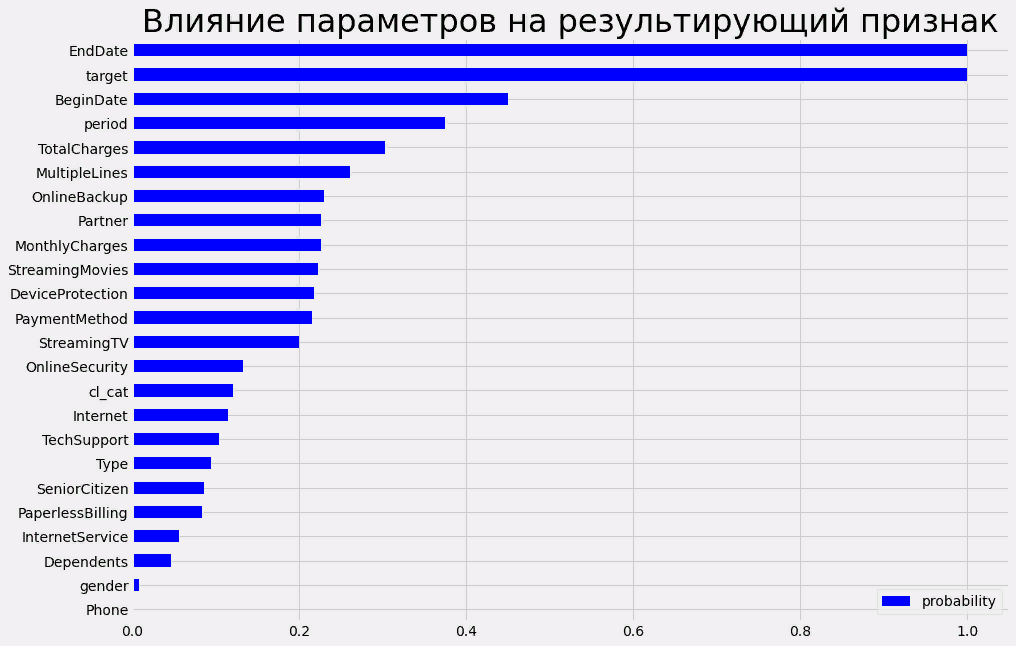



Подготовка данных для машинного обучения.
С учетом того, что в рамках проекта мы планировали использовать разные модели машинного обучения, было подготовлено 2 набора данных. Один набор данных был закодирован и масштабирован, а другой оставлен в первозданном виде, т.к. в Бустинговых моделях эти функции являются встроенными в пакет.

Изначально, с помощью функции test_train_ split датасет был разбит на тестовую (25%) и тренировочную выборки. Чтобы избежать перекоса в данных, при разбиении была использована стратификация.

После разбиения, для одного набора данных было сделано кодирование категориальных признаков методом прямого кодирования OHE и масштабирование числовых признаков методом стандартизации при помощи StandardScaler для того, чтобы числовые признаки привести к одной размерности.


Борьба с дисбалансом классов методами upsample, downsample не проводилась. Была использована балансировка классов внутри модели;

Перед обучением были удалены признаки BeginDate, EndDate. 

Обучение моделей: 
В рамках выполнения данного проекта были обучены 4 модели: 
 - LogisticRegression,
 - RandomForestClassifier
 - CatBoostClassifier
 - LGBM

Было проведено обучение моделей и их проверка на кросс-валидации, а затем была выбрана лучшая по результатам на трейнинговой выборке.
В результате обучения лучше все себя показала модель CatBosstClassifier, на ней была достигнута метрика ROC_AUC = 0.91

Таблица с результатами обучения на :

                        ROC-AUC
 - LogisticRegression  - 0.793918
 - RandomForest       -  0.820824
 - CatBoostClassifier -  0.911588
 - LGBM	              -  0.879023

Гиперпараметры лучшей модели CatBoost:
 - 'depth' - 4
 - 'l2_leaf_reg' - 1
 - 'learning_rat' - 0.1
 
 
 Random State  = 30723 (дата начала финальног проекта)

В дальнейшем продолжено тестирование модели CatBoostClassifier.
В итоге была обучена модель CatBoostClassifier и на тесте была достигнута метрика ROC-AUC равная 0,91. 

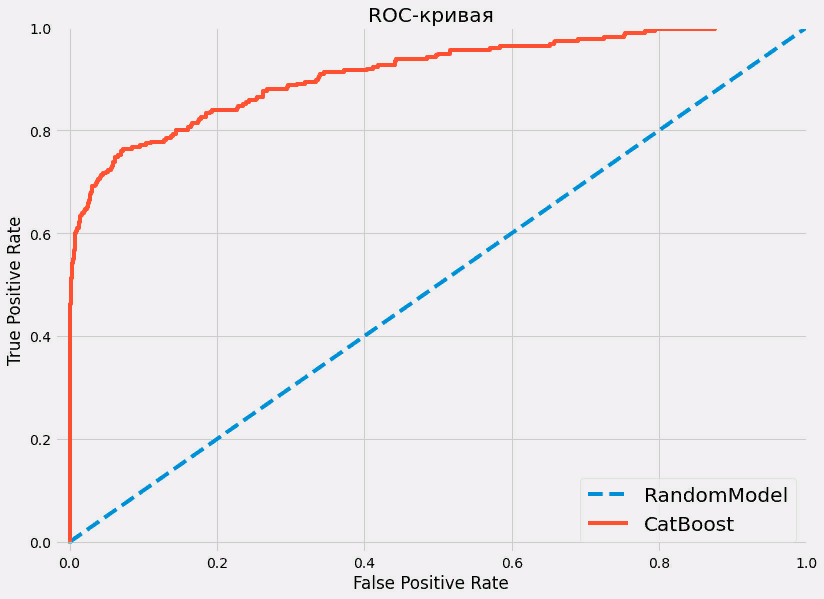 


Была визуализирована важность признаков.
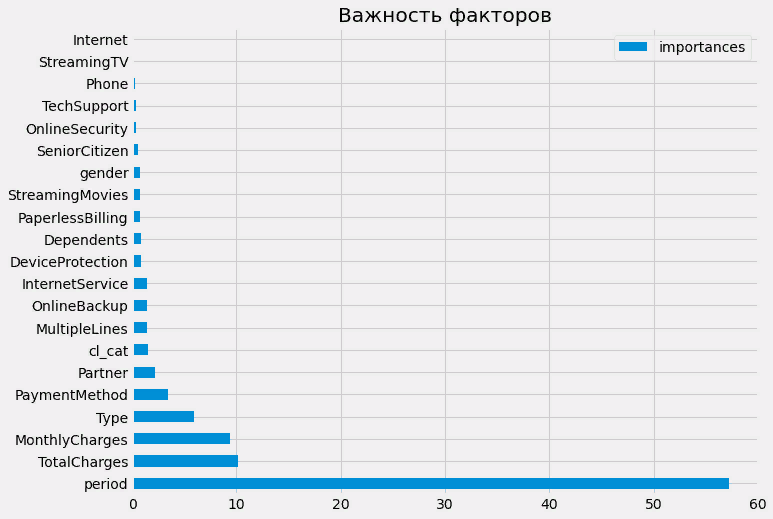
 

Какие трудности возникли и как вы их преодолели?
Особых трудностей, в ходе выполнения работы не было.
